# 1 Importing packages and setting parameters for plots

In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Ignore the warning
warnings.filterwarnings("ignore")

# For graphing purpose 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# 2 Upload Data and Indexing with Time

index data with time column so that rows will be indicated by a date rather than just a standard integer row-index. Since data is monthly, the values in the first column will be in YYYY-MM-DD date format and show the End daya of each Month.

If we assum, Xt = num_of_passengers

Find:

Xt = F(t) = mt + st + zt, where mt is trend, st is seasonality and zt stands for the stationary short-term correlation

In [2]:
import pandas as pd
# Import the data
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
# Set the date as index 
df = df.set_index('Month')
# Select the proper time period for monthly aggreagation
df = df['1949-01-01':'1960-12-01'].resample('M').sum()
df.head()
# df.tail()

,#Passengers
Month,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


# 3 Examine and Prepare the Dataset for Modeling

#### 3-1 Check the Data for Common Time Series Patterns

It’s important to check any time series data for patterns that can affect the results, and can inform which forecasting model to use. Some common time series data patterns are:

1) $Level$:	The average value in the series (white noise)

2) $Trend$:	Increases, decreases, or stays the same over time

3) $Seasonal$: or Periodic	Pattern repeats periodically over time

4) $Cyclical$:	Pattern that increases and decreases but usually related to non-seasonal activity, like business cycles

5) $Random or Irregular Variations$:	Increases and decreases that don’t have any apparent pattern

Most time-series data will contain one or more, but probably not all of these patterns. It’s still a good idea to check for them since they can affect the performance of the model and may even require different modeling approaches.

Two great methods for finding these data patterns are (a) visualization and (b) decomposition.

###### Visualization of Data in TS

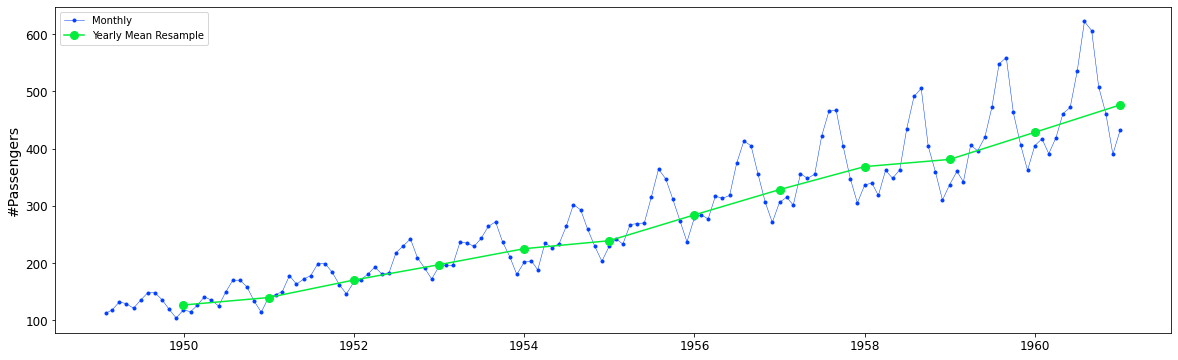

In [3]:
import warnings
import matplotlib.pyplot as plt
y = df['#Passengers']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Monthly')
ax.plot(y.resample('Y').mean(),marker='o', markersize=8, linestyle='-', label='Yearly Mean Resample')
ax.set_ylabel('#Passengers')
ax.legend();

In the picture above, we can look at the basic up/down patterns, overall trend, anomalies, and generally get a sense of what kind of data we’re dealing with. This is just a gut check of the data without going too deep. If there are any very strange anomalies, we might reach out to a subject matter expert to understand possible causes. We are also looking here for any red flags like missing data or other obvious quality issues.

###### Decomposition of Data in TS

By looking at the graph of # of Passengers data above, we can see a general increasing trend with some pattern of seasonal or cyclical changes. The next step is to decompose the data to view more of the complexity behind the linear visualization. A useful Python function called seasonal_decompose within the 'statsmodels' package can help us to decompose the data into four different components: (I) Observed, (II) Trended, (III) Seasonal, (IV) Residual

In [4]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

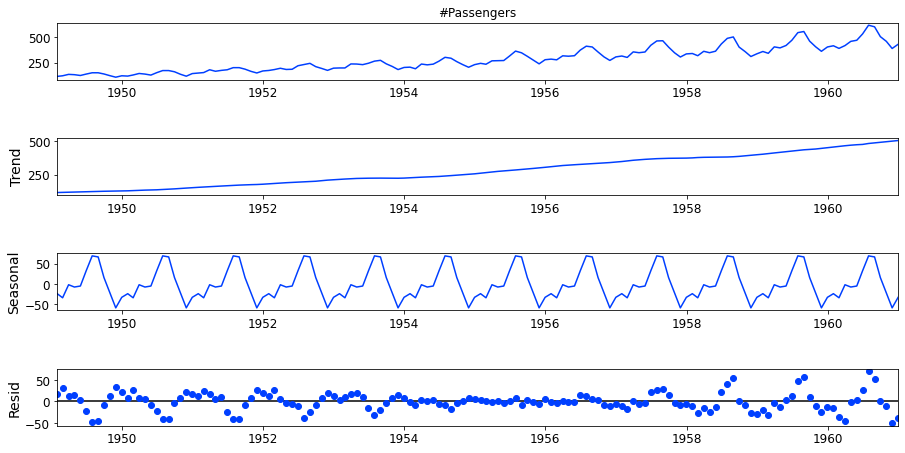

In [5]:
seasonal_decompose(y)

In the picture above, after looking at the four pieces of decomposed graphs, we can tell that # of passengers has an overall increasing trend as well as a yearly seasonality. Depending on the components of our dataset like trend, seasonality, or cycles, our choice of model will be different. Evaluating and choosing models will be discueed later.

#### 3-2 Check for Stationarity

Next, we need to check whether the dataset is stationary or not. A dataset is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time.

Most time series datasets related to business activity are not stationary since there are usually all sorts of non-stationary elements like trends and economic cycles. But, since most time series forecasting models use stationarity—and mathematical transformations related to it—to make predictions, we need to ‘stationarize’ the time series as part of the process of fitting a model.

Two common methods to check for stationarity are (a) Visualization and (b) the Augmented Dickey-Fuller (ADF) Test. 


##### Method (a) Vidualization for stationarity

This method graphs the rolling statistics (mean and variance) to show at a glance whether the standard deviation changes substantially over time

In [6]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(y_timeseries, orig_data_title):
    
    #Determing rolling statistics
    rolmean = pd.Series(y_timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(y_timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(y_timeseries, label= orig_data_title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

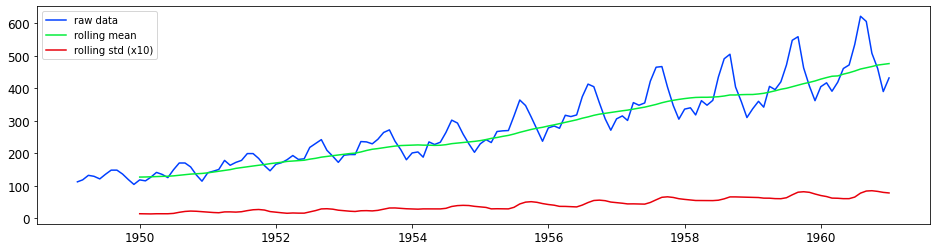

In [7]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

For a time-series data to be stationary, it must have 3 conditinos: Expectation or Avergae over time should be zero, Variance over time (or std) should be constant, and also the auto-coreation should only depend on time lag not the time. We do not check the 3rd condition inthe graph above, but just the first two.

From picture above, we can confidently conclude that our data is not stationary since the E[y] is not zero, and it has an increasing trend.

If in some cases it is not clear that if it is stationary or not, we can use ADF test method.

##### Method (b) the Augmented Dickey-Fuller (ADF) Test

The ADF approach is essentially a statistical significance test that compares the p-value with the critical values and does hypothesis testing. Using this test, we can determine whether the processed data is stationary or not with different levels of confidence.

In [8]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(y_timeseries, dataDescription):
    print(' > Is the {} stationary ?'.format(dataDescription))
    dftest = adfuller(y_timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: \t {:6.2f} -> The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [9]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = 0.815
P-value = 0.992
Critical values :
	1%: 	  -3.48 -> The data is not stationary with 99% confidence
	5%: 	  -2.88 -> The data is not stationary with 95% confidence
	10%: 	  -2.58 -> The data is not stationary with 90% confidence


Looking at both the visualization and ADF test, we can tell that our original data is non-stationary. 

#### 3-3 Make the Data Stationary

To proceed with our time series analysis, we need to stationarize the dataset. There are many approaches to stationarize data, but we’ll use (a) de-trending, (b) differencing, and then (c) a combination of the two.

##### Method (a) Deterending:
This method removes the underlying trend in the time series:

 > Is the de-trended data stationary ?
Test statistic = -2.481
P-value = 0.120
Critical values :
	1%: 	  -3.49 -> The data is not stationary with 99% confidence
	5%: 	  -2.89 -> The data is not stationary with 95% confidence
	10%: 	  -2.58 -> The data is not stationary with 90% confidence


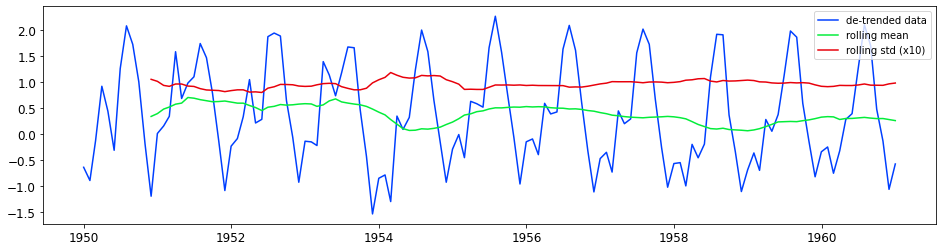

In [10]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

It seems that the deterending removes the "terend" in the data, but the seasonality which is another source of non-stationarity still is there.

The plot shows that the data is not stationary yet, indicated by the relative smoothness of the rolling mean and rolling standard deviation after running the ADF test again.

##### Method (b) Differencing:

Overall differencing is good way to remove both trend and seasonality. When seasonality presents in the data, the order of differencing shoud be selected as the time period of seasonality.

Since the sample dataset has a 12-month seasonality, I used a 12-lag difference:

 > Is the 12 month lag_ed differenced data stationary ?
Test statistic = -3.383
P-value = 0.012
Critical values :
	1%: 	  -3.48 -> The data is not stationary with 99% confidence
	5%: 	  -2.88 -> The data is  stationary with 95% confidence
	10%: 	  -2.58 -> The data is  stationary with 90% confidence


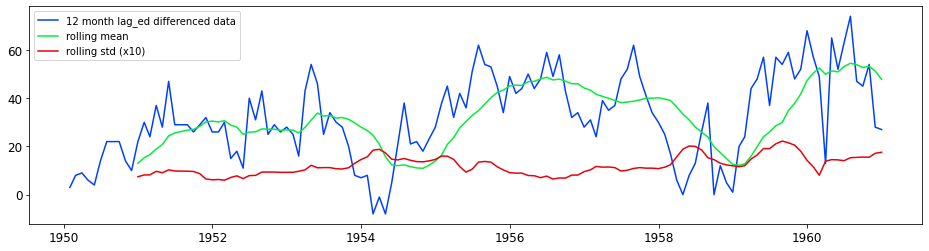

In [11]:
# Differencing
y_12lag =  y - y.shift(12) # since we have DataFrame for every month at each row, shifting 12, means shifting 12 months

test_stationarity(y_12lag,'12 month lag_ed differenced data')
ADF_test(y_12lag,'12 month lag_ed differenced data')

This method did not perform as well as the de-trending did, as indicated by the ADF test which is not stationary within 99 percent of the confidence interval.

##### Methid (c): Combining Detrending and Differencing

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -3.181
P-value = 0.021
Critical values :
	1%: 	  -3.49 -> The data is not stationary with 99% confidence
	5%: 	  -2.89 -> The data is  stationary with 95% confidence
	10%: 	  -2.58 -> The data is  stationary with 90% confidence


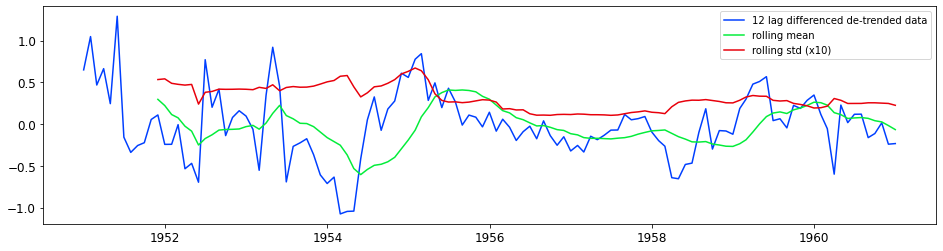

In [12]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

# 4 Create Training & Testing Datasets

In [13]:
split_point = int(len(y)*0.8) # 80% data for training

y_to_train = y[:split_point] # dataset to train
y_to_val = y[split_point:] # last X months for test  
predict_date = len(y) - len(y[:split_point]) # the number of data points for the test set

# 5 What TS Prediction Model to Choose

Not all of the following models are suitable for the sample dataset we’re using here. We walk through them anyways to describe some of the options, and to show how and why not all models are appropriate for all datasets.

The appropriate model for our time-series data will depend on the data’s particular characteristics, for example, if the dataset has an overall trend or seasonality.

The follwing metrics are used to evaluate the final mode:
(I) RMSE: Root Mean Squared Error
(II) MAE: Mean Absolute Error

Four TS forecasting models:

(I) **Simple Exponential Smoothing (SES):** for data without trend or seasonality. In aother words, for a TS with no clear pattern and is a white noise.

(II) **Holt’s Linear Trend Method:** for data with a trend but no seasonality

(III) **Holt-Winters’ Seasonal Method (Exponential Smoothing):** for data with trend and/or seasonality

(IV) **SARIMA:** for data with trend and/or seasonality


#### 5-1 Simple Exponential Smoothing (SES):

This model calculates the forecasting data using weighted averages. One important parameter this model uses is the smoothing parameter: $\alpha$, and you can pick a value between 0 and 1 to determine the smoothing level. When $\alpha = 0$, the forecasts are equal to the average of the historical data. When $\alpha = 1$, the forecasts will be equal to the value of the last observation.

You can either choose a specific $\alpha$ (e.g., in the sample code, I used 0.8) or use the Python ‘statsmodels’ module to automatically find an optimized value for the dataset. I usually use the auto-optimization approach which gives us the lowest error, but if you want to be more conservative or aggressive, you can specify $\alpha$.

In [14]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    # specific smoothing level (alpha)
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of the forecasts with smoothing level (constant alpha) of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto alpha-optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

The Root Mean Squared Error of the forecasts with smoothing level (constant alpha) of 0.2 is 90.67
The Root Mean Squared Error of our forecasts with auto alpha-optimization is 92.98


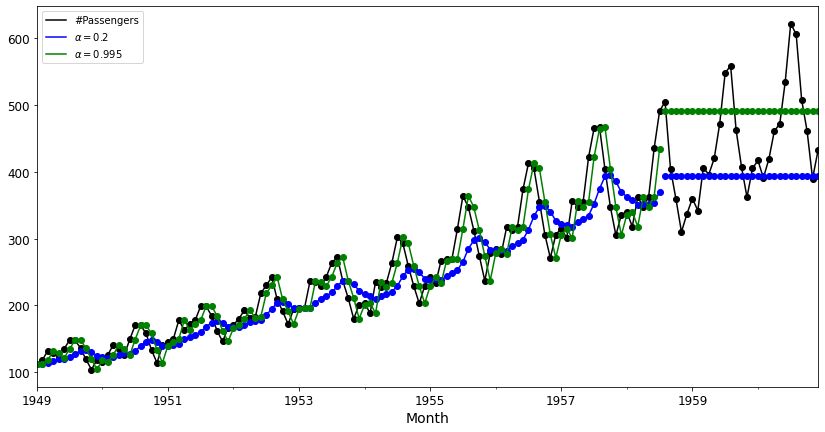

In [15]:
ses(y, y_to_train,y_to_val,0.2,predict_date)

The visualization of the results for the simple exponential smoothing (SES) forecast model shows the difference between the specified α (blue line) and the auto-optimized α (green line). As you can see from the graph, SES will predict a flat, forecasted line since the logic behind it uses weighted averages. Even though the RMSE is low, it does not predict any fluctuation. Since most time series data has some kind of trend or seasonality, this model can be used to get a sense of a baseline for comparison. 

#### 5-2 Holt’s Linear Trend Method

Suitable for time series data **with a trend component but without a seasonal component.**

Expanding the SES method, the Holt method helps you forecast time series data that has a trend. In addition to the level smoothing parameter $\alpha$ introduced with the SES method, the Holt method adds the trend smoothing parameter $\beta^{*}$. Like with parameter $\alpha$, the range of $\beta^{*}$ is also between 0 and 1.

The sample code below contains two different variants within the Holt method. Both fits have the $\alpha = 0.6$ , $\beta^{*} = 0.2$ as parameter values.

The **fit1 is the default Holt’s additive model (linear trend)**, and the **fit2 is an exponential model (exponential trend)**. An exponential model would be appropriate for situations where the increase or decrease starts slowly but then accelerates rapidly.

In [16]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,predict_date, smoothing_level,smoothing_slope ):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

The Root Mean Squared Error of Holts Linear trend 345.79
The Root Mean Squared Error of Holts Exponential trend 783.89


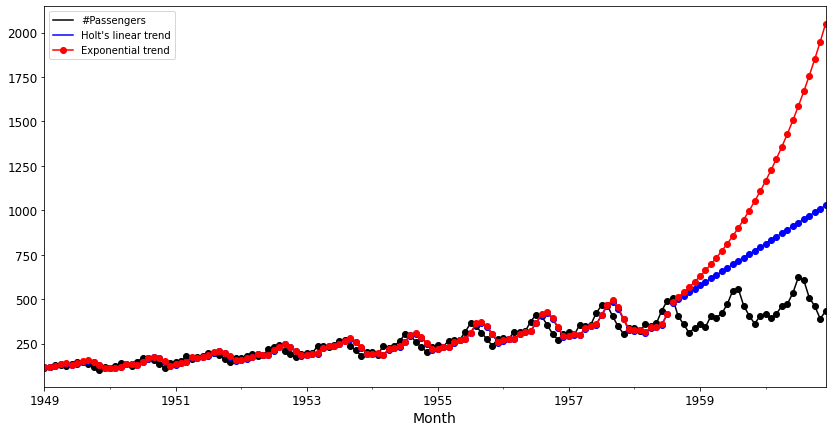

In [17]:
holt(y, y_to_train, y_to_val, predict_date, smoothing_level=0.6, smoothing_slope=0.2)


Looking at the visualization for the Holt method, we see how the linear trend (blue line) and exponential trend (red line) compare to each other and to the order volumes. Compared with SES, Holt captures more of the trend of the data. However, as you can see from the visual, the trend it discovered is too dramatic and would be very unlikely to take place in real life.

#### 5-3 Holt-Winters’ Seasonal Method (Exponential Smoothing)

Suitable for time series data with trend and/or seasonal components

The Holt-Winters model extends Holt to **allow the forecasting of time series data that has both trend and seasonality**, and this method includes this seasonality smoothing parameter: $\gamma$.

There are two general types of seasonality: Additive and Multiplicative. 

(I) **Additive**: xt = Trend + Seasonal + Random

Seasonal changes in the data stay roughly the same over time and don’t fluctuate in relation to the overall data.

(II) **Multiplicative**: xt = Trend * Seasonal * Random

The seasonal variation changes in relation to the overall changes in the data. So, if the data is trending upward, the seasonal differences grow proportionally as well.

Here’s a helpful visual:

Picture at: https://goo.gl/szKmgo


Once we figure out which type of seasonality we’re dealing with in our data, we can identify the frequency of seasonality or m. For a monthly data (each row one month) with a quarterly seasonal pattern, m = 4, while for a monthly seasonal data pattern, m = 12. Our sample data has a yearly seasonal pattern with few years of data, and we aggregated it by month, so each data point is one month, so m = 12.

The Python statsmodels module provides users with a range of parameter combinations based on the trend types, seasonality types, and other options for doing **Box-Cox transformations**. This package is kind of like the time series version of grid search for hyperparameter tuning. To find out more, see this: https://otexts.com/fpp2/holt-winters.html

In [18]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y, y_to_train, y_to_test, seasonal_type, seasonal_period, predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive': # seasonal='add'
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  #seasonal='mul' 
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=12 and a Box-Cox transformation 37.63
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=12 and a Box-Cox transformation 24.98


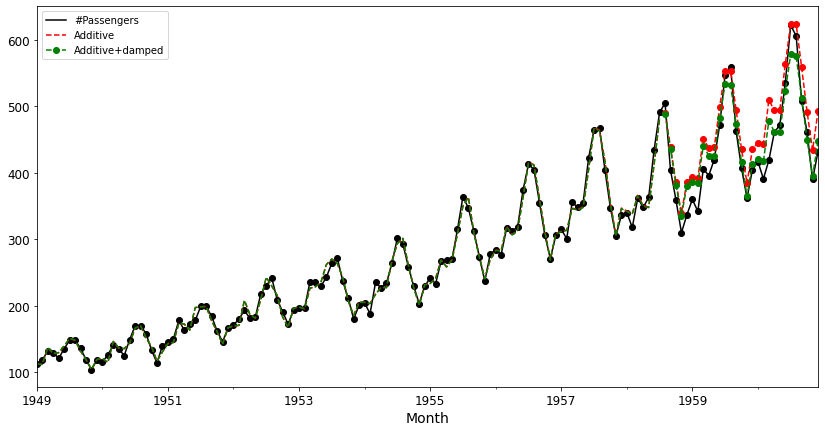

In [19]:
holt_win_sea(y, y_to_train,y_to_val,'additive',12, predict_date)


The Root Mean Squared Error of additive trend, multiplicative seasonal of period season_length=12 and a Box-Cox transformation 23.63
The Root Mean Squared Error of additive damped trend, multiplicative seasonal of period season_length=12 and a Box-Cox transformation 23.63


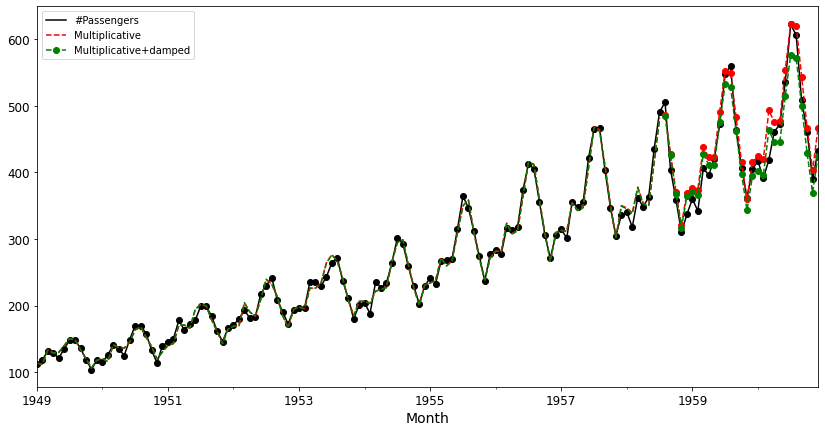

In [20]:
holt_win_sea(y, y_to_train,y_to_val,'multiplicative',12, predict_date)

The visualization of the results for the Holt-Winters method shows the additive (red line) compared to the additive + damped (green line) trends. Based on the visualization, we see that the Holt-Winters model fits the actual data best, so far. However, the RMSE is not better than the results from the simple SES model. And we can also tell that the forecast starts to drop off towards the end.

#### 5-4 SARIMA

Suitable for time series data with trend and/or seasonal components

While exponential smoothing models use weighted averages of past observations to forecast new values, Auto-Regressive Integrated Moving Average or ARIMA models look at autocorrelations or serial correlations in the data. In other words, ARIMA models look at differences between values in the time series. SARIMA builds upon the concept of ARIMA but extends it to model the seasonal elements in your data. 
 
You’ll notice that SARIMA includes several parameters that can be tuned to achieve optimal performance:
 
**Trend Elements**:

p: Trend autoregression order.

d: Trend difference order.

q: Trend moving average order.

**Seasonal Elements**:

P: Seasonal autoregressive order.

D: Seasonal difference order.

Q: Seasonal moving average order.

m: The number of time steps for a single seasonal period.

In order to get the best prediction, it’s important to find the values of SARIMA(p,d,q)(P,D,Q)m that optimize a metric of interest. We will just use a "grid search" to iteratively explore different combinations of parameters.

The evaluation metric we’ll use for the grid search is the **AIC (Akaike Information Criterion)** value. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. In general, we want to pick the combination with the lowest AIC value.

Help sources: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

Additional codes can be added: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [25]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [26]:
sarima_grid_search(y,seasonal_period=12)

The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:920.3192974988737


The grid search tested all possible combinations of variables, and printed out the set that resulted in the lowest AIC, and we can see that SARIMA(0, 1, 1)x(1, 1, 1, 12) has the lowest AIC value. Since this method chose the best parameters, we will use this method to fit our model and compare the results with all the previous models discussed above.

In [27]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

In [28]:
list(y.index)[split_point]

Timestamp('1958-08-31 00:00:00', freq='M')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3198      0.074     -4.299      0.000      -0.466      -0.174
ar.S.L12      -0.1526      0.093     -1.645      0.100      -0.334       0.029
sigma2       143.5585     17.846      8.044      0.000     108.581     178.536


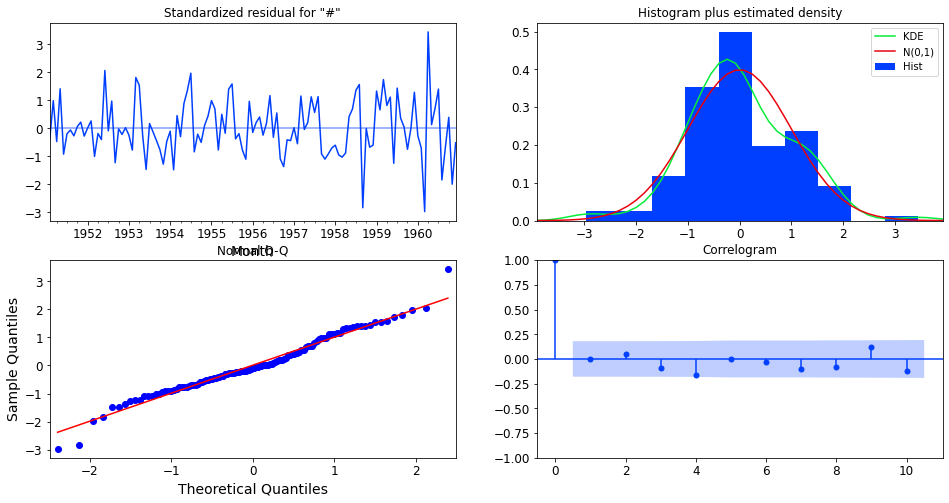

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 16.71


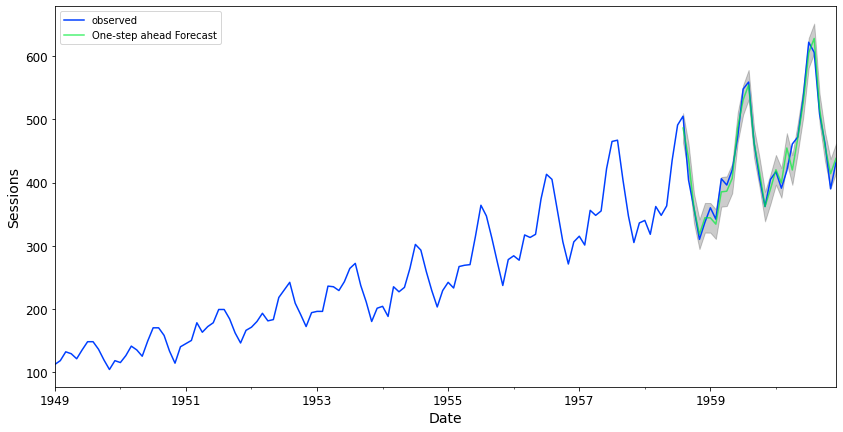

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 33.54


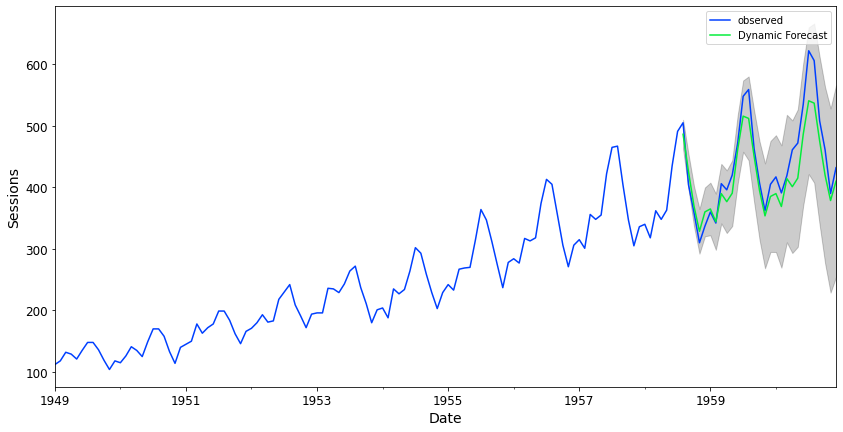

In [29]:
model = sarima_eva(y,(0, 1, 1),(1, 1, 0, 12),12,'1958-08-31',y_to_val)

Here are the visualizations for the SARIMA method. Compared with the results of all the previous models, we can be confident saying the SARIMA model best captures both the seasonality and trend of our dataset. Its forecasted results are closest to the actual # of Passengers.

In addition to using the Root Mean Squared Error (RMSE) metric, I also ran plot_diagnostics( ), which is a really valuable function to ensure that none of the assumptions made by the model have been violated, and that there is no unusual behavior. The dynamic=False argument ensures that we produce one-step-ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point. Unfortunately, this is a function that can only be built inside the SARIMA and ARIMA packages, so we cannot print out the same results for the other models we have considered.

There are a few things to check to get the most out of these diagnostic graphs:

1. The top left plot shows the residuals over time. We do not want to see any obvious seasonality here and the messier it is, the better we can say we found the trend and seasonality in our data and removed the noise.

2. In the top-right plot, we want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.

3. In the bottom left qq-plot, you see the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).

4. The autocorrelation visual (called a “correlogram”) on the bottom right shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

By validating all the four points above, we can conclude that this model’s residuals are near normally distributed. This indicates we have found a well-fit model suitable for our dataset.

If we were only concerned with achieving the lowest Root Mean Squared Error, we would choose the Simple Exponential Smoothing (SES) model to use since it produced the smallest error. In many business cases where longer-term forecasting with more nuanced visualizations are needed in our overall analysis, the SARIMA model is preferred. 

# 6 Forecasting

Now that we have a well-fit model, let’s do some forecasting!

To get the forecast for # of passengers in the next year, we enter steps=12. The results produce both a table showing the Predicted_Mean, Lower Bound and Upper Bound, and the prediction graphs.

In [30]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    # Confidence Interval
    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    # plot the data used for forecasting (not the predicted)
    ax = y.plot(label='observed', figsize=(14, 7))
    
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

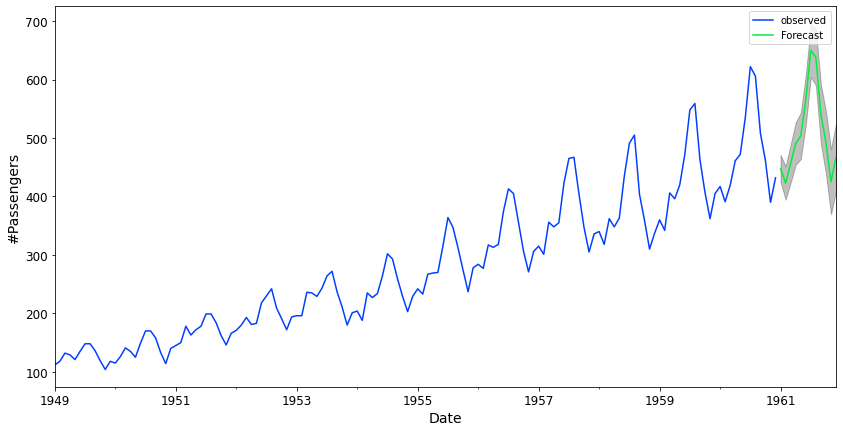

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,1961-01-31,447.66115581,424.17767341,471.14463820
1,1961-02-28,422.88180713,394.48030465,451.28330960
2,1961-03-31,456.37473807,423.78920845,488.96026768
3,1961-04-30,490.44050449,454.15017330,526.73083567
4,1961-05-31,503.42406288,463.77359586,543.07452990
5,1961-06-30,564.74566732,521.99837579,607.49295884
6,1961-07-31,650.06727175,604.43282939,695.70171411
7,1961-08-31,638.18696996,589.83747433,686.53646558
8,1961-09-30,540.49213279,489.57214531,591.41212026
9,1961-10-31,492.11890005,438.75208900,545.48571110


In [31]:
# model object is created above using SARIMA method

final_table = forecast(model,12,y)
final_table.head(10)

You can see from the visualization that our model clearly captured the seasonality as well as the increasing trend of the # of passengers.

The green line in the graph represents the expected future data based on the forecasting model we built. The green line represents the average forecasted value for each month, and we would not be surprised to see the actual numbers track to this line for the most part. But there is no guarantee of this!

The gray area above and below the green line represents the 95 percent confidence interval and as with virtually all forecasting models, as the predictions go further into the future, the less confidence we have in our values. In this case, we are 95 percent confident that the actual sales will fall inside this range. But, there is a chance the actuals could fall completely outside this range also. The larger the future time period for which we want to predict, the larger this confidence range will be (that is, the less precise our forecast is).

When sharing results with stakeholders, be sure they understand what the confidence interval really means and why it’s important. The results should not be seen as a guaranteed or even expected result, but only as a reference that provides a general picture of the yearly pattern. Lots of uncontrolled factors may heavily influence real-life sales. The sudden onset and huge impacts of COVID-19 present a perfect example of unexpected factors affecting future sales.

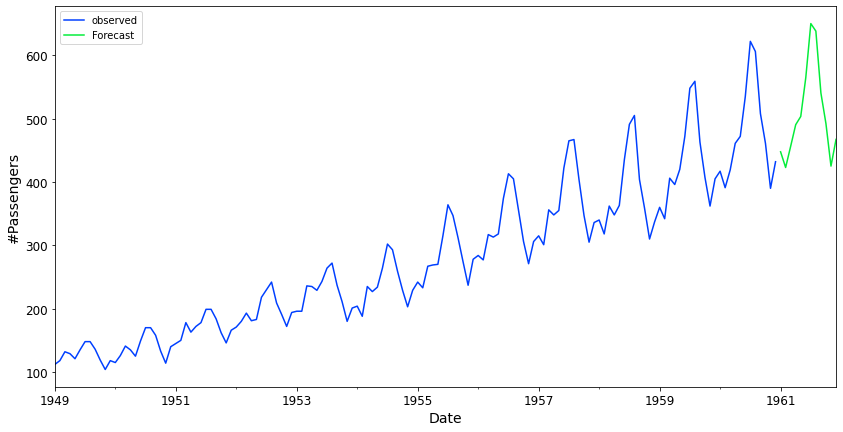

In [32]:
### Graphs without the confident interval 
pred_uc = model.get_forecast(steps=12)
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

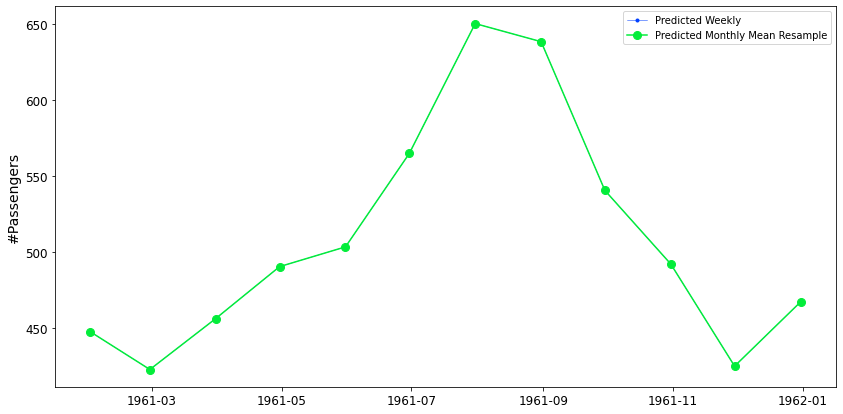

In [33]:
### Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('#Passengers')
ax.legend();